In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import time

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import gridspec

import numpy as np
import scipy as sp
import scipy.sparse as sparse
import numpy.linalg as linalg

from scipy import interpolate
from optimize.snopt7 import SNOPT_solver

In [11]:

# 
# Attempt to solve for the positions of a randomly scattered set of UWB units
#

# Number of units
n = 10
dim = 3
known = 3

#
# Create a random 3D pointset
#
points_truth = np.matrix(np.random.randn(n, dim) * 10)
print "Points: ", points_truth.shape
print points_truth

#
# Calculate the pairwise distances
#
pairwise_dist_truth = sp.spatial.distance.pdist(points_truth)
print "Pairwise distances:", pairwise_dist_truth.shape
print pairwise_dist_truth

Points:  (10, 3)
[[-12.39804825  -4.54670336 -24.79775224]
 [-10.00966385 -14.91463349   2.94005266]
 [ -6.14919081   5.0278619    1.43258022]
 [  5.72741266  -8.4203357   -3.93039909]
 [  5.86981942  -5.46900258  -7.23251517]
 [  7.03442308   7.44346929   6.26991506]
 [ -2.90804199  -1.10176276  19.14020897]
 [ -2.24127009 -23.63231742   2.38924337]
 [-16.44649872   1.8929934   -3.72269809]
 [ -5.45272043  23.79026365 -10.54259993]]
Pairwise distances: (45,)
[ 29.7083183   28.61382288  27.91028105  25.35947906  38.55625933
  45.08294877  34.73547951  22.40574822  32.47199787  20.368575    18.3585018
  21.09168245  28.31030983  22.44267131  11.6897111   19.19170166
  41.23853438  18.72616554  18.15832175  14.24930323  19.01676787
  28.94119774  11.93477461  22.26921036   4.43109664  18.90542234
  25.69796769  18.29869321  24.4558836   34.73095574  18.71907726
  28.13617268  22.09692323  23.7599633   31.5477611   18.37166481
  32.66194446  26.1153937   26.5670303   28.08318584  26.73893

In [12]:
#
# Set up optimization problem to solve for positions
#
snopt = SNOPT_solver()
snopt.setOption('Verbose',True)
snopt.setOption('Solution print',False)
snopt.setOption('Print file','uwb1.out')
snopt.setOption('Iteration limit',8000)
snopt.setOption('Print level',3)
snopt.setOption('Major optimality',2e-12)

inf = 1.0e20

x = np.zeros((n, dim))
x = np.matrix(x)
x0 = x.A1

xlow = np.matrix(-inf + np.zeros((n, dim)))
xupp = np.matrix( inf + np.zeros((n, dim)))

#
# I have some known positions
#
for i in range(known):
    xlow[i,:] = points_truth[i,:]
    xupp[i,:] = points_truth[i,:]

low_F = np.array([-inf])
upp_F = np.array([ inf])

def objF(status,x,needF,needG,cu,iu,ru):
    points_estimated = x.reshape((n, dim))
    pairwise_dist_estimated = sp.spatial.distance.pdist(points_estimated)

    return status, [np.sum( (pairwise_dist_estimated - pairwise_dist_truth)**2 )]

a = time.time()
snopt.snopta(name="UWB_1",usrfun=objF,x0=x0,xlow=xlow.A1,xupp=xupp.A1,
             Flow=low_F,Fupp=upp_F,ObjRow=1)
b = time.time()

print "Solved in %.4fs" % (b - a)

print "Value of objective function: %.8f" % snopt.F[0]

 --> Linear component of Jacobian not provided
 --> Nonlinear component of Jacobian not provided
  Could not determine Jacobian structure from user input
  Calling snJac...
 --> Initial xstate not provided; setting to 0
 --> Initial Fstate not provided; setting to 0
----------------------------------------------------------------------------------
 SNOPT python interface   (Feb 2015)
   Problem: UWB_1
   # variables = 30; # constraints = 1 

     Name state(j)      low(j)           x(j)           upp(j)        mul(j)
x:
        0       0   -1.239805e+01    0.000000e+00   -1.239805e+01    0.000000e+00
        1       0   -4.546703e+00    0.000000e+00   -4.546703e+00    0.000000e+00
        2       0   -2.479775e+01    0.000000e+00   -2.479775e+01    0.000000e+00
        3       0   -1.000966e+01    0.000000e+00   -1.000966e+01    0.000000e+00
        4       0   -1.491463e+01    0.000000e+00   -1.491463e+01    0.000000e+00
        5       0    2.940053e+00    0.000000e+00    2.940053e+0

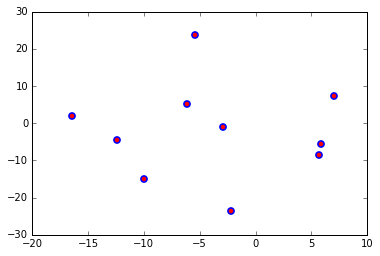

In [13]:
#
# Check the error between solved-for and actual pointset
#
points_estimated = snopt.x.reshape((n, dim))

plt.scatter(points_truth[:,0],points_truth[:,1], c="blue", alpha=1, s=60, linewidth=0)
plt.scatter(points_estimated[:,0],points_estimated[:,1], c="red", alpha=1, linewidth=0)